In [43]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    Activation,
    GlobalAveragePooling2D,
    Input,
    Add,
)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import kagglehub
from datetime import datetime

In [ ]:
path = kagglehub.dataset_download("gauravsharma99/ck48-5-emotions")

In [ ]:
dataset_path = os.path.join(path, "CK+48")
sub_folders = os.listdir(dataset_path)
labels = []
images = []

for sub_folder in sub_folders:
    sub_folder_index = sub_folders.index(sub_folder)
    label = sub_folder_index
    path = os.path.join(dataset_path, sub_folder)
    sub_folder_images = os.listdir(path)

    for image in sub_folder_images:
        image_path = os.path.join(path, image)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (48, 48))
        images.append(image)
        labels.append(label)

In [ ]:
images_x = np.array(images)
labels_y = np.array(labels)
images_x = images_x / 255
print(images_x)
num_classes = len(sub_folders)
labels_y_encoded = tf.keras.utils.to_categorical(labels_y, num_classes)
print(labels_y_encoded)

In [ ]:
X_train, X_test, Y_train, Y_test= train_test_split(images_x, labels_y_encoded,test_size=0.25, random_state=10)

In [ ]:
input = Input(shape=(48, 48, 1))
conv1 = Conv2D(
    32, (3, 3), padding="same", strides=(1, 1), kernel_regularizer=l2(0.001)
)(input)
conv1 = Dropout(0.1)(conv1)
conv1 = Activation("relu")(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(
    64, (3, 3), padding="same", strides=(1, 1), kernel_regularizer=l2(0.001)
)(pool1)
conv2 = Dropout(0.1)(conv2)
conv2 = Activation("relu")(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(
    128, (3, 3), padding="same", strides=(1, 1), kernel_regularizer=l2(0.001)
)(pool2)
conv3 = Dropout(0.1)(conv3)
conv3 = Activation("relu")(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(
    256, (3, 3), padding="same", strides=(1, 1), kernel_regularizer=l2(0.001)
)(pool3)
conv4 = Dropout(0.1)(conv4)
conv4 = Activation("relu")(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

flatten = Flatten()(pool4)
dense1 = Dense(128, activation="relu")(flatten)
drop1 = Dropout(0.1)(dense1)
output = Dense(num_classes, activation="sigmoid")(drop1)

In [ ]:
model = Model(inputs=input, outputs=output)
model.compile(optimizer="adam", loss=["categorical_crossentropy"], metrics=["accuracy"])
model.summary()

In [34]:
checkpoint_path = "model_checkpoint.keras"
checkpointer = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
)
callback_list = [checkpointer]

In [36]:
save = model.fit(
    X_train,
    Y_train,
    batch_size=32,
    validation_data=(X_test, Y_test),
    epochs=50,
    callbacks=callback_list,
)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2600 - loss: 1.8320
Epoch 1: loss improved from inf to 1.76943, saving model to model_checkpoint.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.2621 - loss: 1.8287 - val_accuracy: 0.3191 - val_loss: 1.6959
Epoch 2/50
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3545 - loss: 1.6586
Epoch 2: loss improved from 1.76943 to 1.63781, saving model to model_checkpoint.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3550 - loss: 1.6564 - val_accuracy: 0.3191 - val_loss: 1.6303
Epoch 3/50
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3851 - loss: 1.5810
Epoch 3: loss improved from 1.63781 to 1.56298, saving model to model_checkpoint.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3851 - loss: 1.5791 - val_accuracy: 0.4468 - val_loss: 1.5074
Epoch 4/50
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5559 - loss: 1.3447
Epoch 4: loss improved from 1.56298 to 1.17669, saving 

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

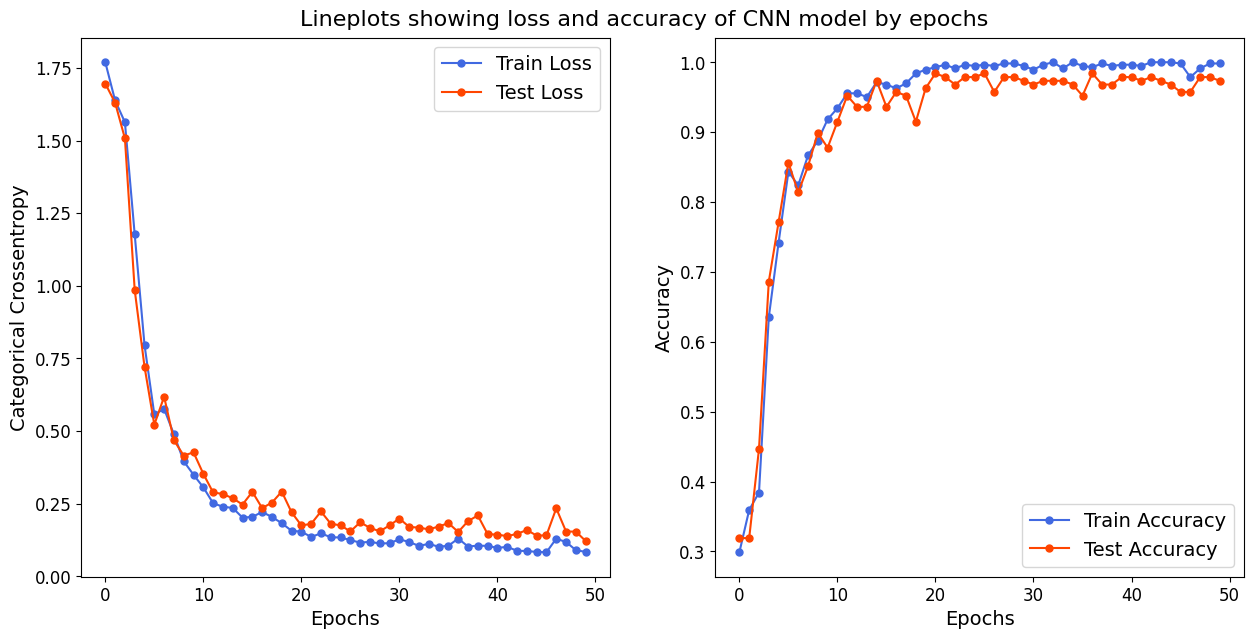

In [37]:
train_loss = save.history["loss"]
test_loss = save.history["val_loss"]
train_accuracy = save.history["accuracy"]
test_accuracy = save.history["val_accuracy"]

fig, ax = plt.subplots(ncols=2, figsize=(15, 7))
ax = ax.ravel()
ax[0].plot(train_loss, label="Train Loss", color="royalblue", marker="o", markersize=5)
ax[0].plot(test_loss, label="Test Loss", color="orangered", marker="o", markersize=5)
ax[0].set_xlabel("Epochs", fontsize=14)
ax[0].set_ylabel("Categorical Crossentropy", fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis="both", labelsize=12)
ax[1].plot(
    train_accuracy, label="Train Accuracy", color="royalblue", marker="o", markersize=5
)
ax[1].plot(
    test_accuracy, label="Test Accuracy", color="orangered", marker="o", markersize=5
)
ax[1].set_xlabel("Epochs", fontsize=14)
ax[1].set_ylabel("Accuracy", fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(axis="both", labelsize=12)
fig.suptitle(
    x=0.5,
    y=0.92,
    t="Lineplots showing loss and accuracy of CNN model by epochs",
    fontsize=16,
)

In [47]:
cam_port = 0
cam = cv2.VideoCapture(cam_port)
result, image = cam.read()
if result:
  now = datetime.now()
  current_time = now.strftime("%Y-%m-%d %H:%M:%S")
  current_time = current_time.replace(" ", "_").replace(":", "-")
  cv2.imwrite(f"{current_time}.png", image)
  print(f"Captured image at path {current_time}.jpg")
  cam.release()
else:
  print("Failed to capture image")
  cam.release()

Captured image at path 2024-11-05_10-53-09.jpg
